# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/碩一上學期/人工智慧/hw1')

Mounted at /content/drive


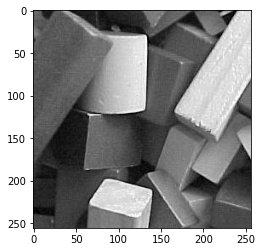

image.shape:  (256, 256)


In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("blocks.jpg",0)
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)


## Step 1. Gaussian filter

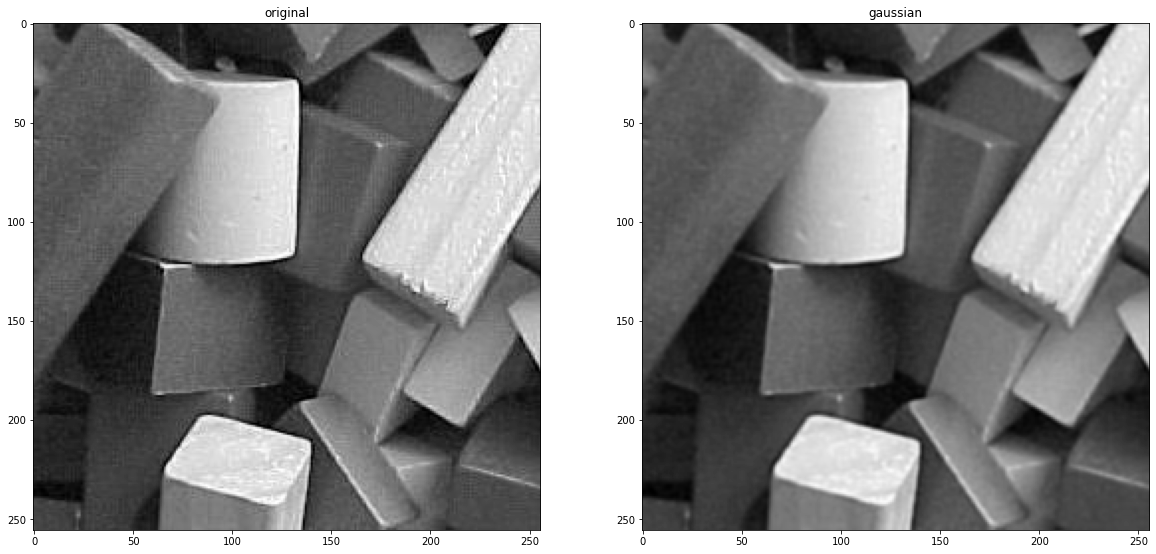

original shape:  (256, 256)
gaussian shape:  (256, 256)


In [4]:
def padding_img(img,k_size,style='edge'):
  # ------------ To do ------------- #
  return cv2.copyMakeBorder(img, k_size,k_size,k_size,k_size, cv2.BORDER_REFLECT)

def gaussian_kernel(size):
  # ------------ To do ------------- #
  sigma = 0.3*((size-1)*0.5 - 1) + 0.8
  a = cv2.getGaussianKernel(size, sigma)
  return a*a.T

KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row,col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    # ------------ To do ------------- #
    padding_size = (KernelSize-1)//2
    padimg = padimg.astype(float)
    resx = resx.astype(float)
    for i in range(row):
      for j in range(col):
        for l in range(-padding_size, padding_size+1):
          for m in range(-padding_size, padding_size+1):
            resx[i][j] = resx[i][j] + Gaussian_Kernel[l+padding_size][m+padding_size]*padimg[i+padding_size+l][j+padding_size+m]
            resx = np.clip(resx, 0, 255)
    return resx.astype('uint8')

gaussian_image = Gaussian_Filter(KernelSize=KernelSize, image=img_org)
image_list = []
image_list.append(img_org)
image_list.append(gaussian_image)
title_list = []
title_list.append('original')
title_list.append('gaussian')

fig = plt.figure(figsize=(20,40))
for im,ss,i in zip(image_list,title_list,range(0, 2)):
  plt.subplot(1,2,i+1)
  plt.imshow(im, cmap='gray')
  plt.title(ss)
plt.show()

print('original shape: ', img_org.shape)
print('gaussian shape: ', gaussian_image.shape)

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [79]:
def sobel(img, filtering_type):
    h, w = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    horizontal_2 = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    vertical_2 = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        
    Gx = np.zeros((h - 2, w - 2))
    Gx_2 = np.zeros((h - 2, w - 2))
    Gy = np.zeros((h - 2, w - 2))
    Gy_2 = np.zeros((h - 2, w - 2))

    # ------------ To do ------------- #
    #padimg = padding_img(img,3//2)
    angle = np.zeros((h , w ))
    if(filtering_type == 'horizontal'):
      for img_region, i, j in iterate_regions(img=img, kernel_size=3):
        for x in range(3):
          for y in range(3):
            Gx[i][j] = Gx[i][j] + img_region[x][y]*horizontal[x][y]
            Gx_2[i][j] = Gx_2[i][j] + img_region[x][y]*horizontal_2[x][y]
        Gx[i][j] = np.clip(Gx[i][j], 0, 255)
        Gx_2[i][j] = np.clip(Gx_2[i][j], 0, 255)
      Gx = cv2.bitwise_or(Gx, Gx_2)
      output = Gx.copy()
    elif filtering_type == 'vertical':
      for img_region, i, j in iterate_regions(img=img, kernel_size=3):
        for x in range(3):
          for y in range(3):
            Gy[i][j] = Gy[i][j] + img_region[x][y]*vertical[x][y]
            Gy_2[i][j] = Gy_2[i][j] + img_region[x][y]*vertical_2[x][y]
        Gy[i][j] = np.clip(Gy[i][j], 0, 255)
        Gy_2[i][j] = np.clip(Gy_2[i][j], 0, 255)
      Gy = cv2.bitwise_or(Gy, Gy_2)
      output = Gy.copy()
    elif filtering_type == 'magnitude':
      G = np.zeros((h, w))
      horizontal_image, angle = sobel(img=gaussian_image, filtering_type='horizontal')
      horizontal_image = padding_img(horizontal_image,3//2)
      vertical_image, angle = sobel(img=gaussian_image, filtering_type='vertical')
      vertical_image = padding_img(vertical_image,3//2)
      for i in range(G.shape[0]):
        for j in range(G.shape[1]):
          G[i][j] = (horizontal_image[i][j]*horizontal_image[i][j] + vertical_image[i][j]*vertical_image[i][j])**0.5
          a = math.atan2(vertical_image[i][j],horizontal_image[i][j])*180/math.pi
          angle[i][j] = a % 180
      G = np.clip(G, 0, 255)
      output = G
    return output, angle


def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j


gaussian shape:  (256, 256)
horizontal shape:  (256, 256)
vertical shape:  (256, 256)
amplitude shape:  (256, 256)


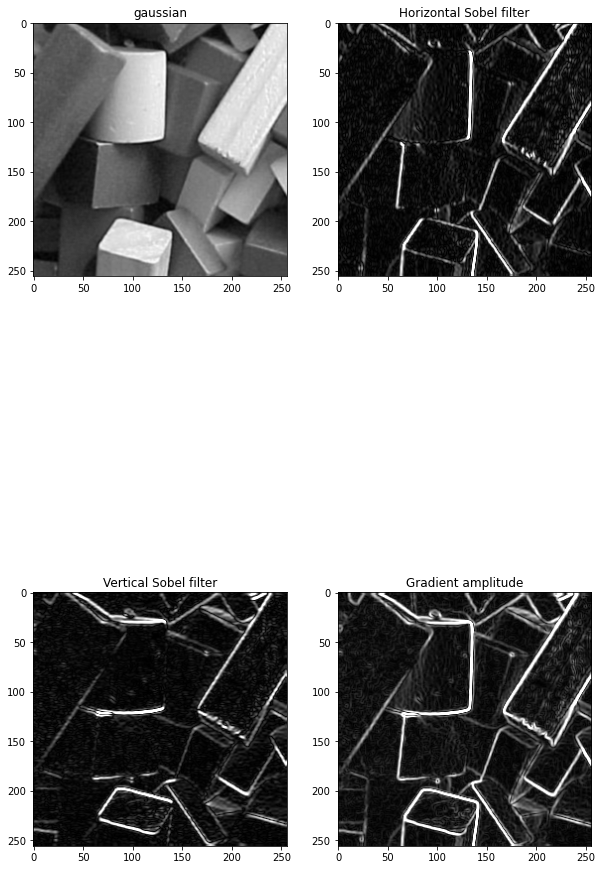

In [80]:
# ------------ To do ------------- #
horizontal_image, angle = sobel(img=gaussian_image, filtering_type='horizontal')
horizontal_image = padding_img(horizontal_image,3//2)
vertical_image, angle = sobel(img=gaussian_image, filtering_type='vertical')
vertical_image = padding_img(vertical_image,3//2)
h, w = gaussian_image.shape
G = np.zeros((h - 2, w - 2))
for i in range(G.shape[0]):
  for j in range(G.shape[1]):
    G[i][j] = (horizontal_image[i][j]*horizontal_image[i][j] + vertical_image[i][j]*vertical_image[i][j])**0.5
G = np.clip(G, 0, 255)
#amplitude_image = G.copy()
amplitude_image = padding_img(G,3//2)

print('gaussian shape: ', gaussian_image.shape)
print('horizontal shape: ', horizontal_image.shape)
print('vertical shape: ', vertical_image.shape)
print('amplitude shape: ', amplitude_image.shape)

fig = plt.figure(figsize=(10,20))
fig.subplots_adjust(hspace=0.1, wspace=0.2)
plt.subplot(2,2,1)
plt.title('gaussian')
plt.imshow(gaussian_image, cmap='gray')

plt.subplot(2,2,2)
plt.title('Horizontal Sobel filter')
plt.imshow(horizontal_image, cmap='gray')

plt.subplot(2,2,3)
plt.title('Vertical Sobel filter')
plt.imshow(vertical_image, cmap='gray')

plt.subplot(2,2,4)
plt.title('Gradient amplitude')
plt.imshow(amplitude_image, cmap='gray')

plt.show()

## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [81]:
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            # ------------ To do ------------- #
            if angle[j][i] <= 22.5 or angle[j][i] > 157.5:
              if gradient_copy[j][i] < gradient_copy[j][i+1] or gradient_copy[j][i] < gradient_copy[j][i-1]:
                gradient_copy[j][i] = 0
            elif angle[j][i] <= 67.5:
              if gradient_copy[j][i] < gradient_copy[j+1][i+1] or gradient_copy[j][i] < gradient_copy[j-1][i-1]:
                gradient_copy[j][i] = 0
            elif angle[j][i] <= 112.5:
              if gradient_copy[j][i] < gradient_copy[j+1][i] or gradient_copy[j][i] < gradient_copy[j-1][i]:
                gradient_copy[j][i] = 0
            elif angle[j][i] <= 157.5:
              if gradient_copy[j][i] < gradient_copy[j-1][i+1] or gradient_copy[j][i] < gradient_copy[j+1][i-1]:
                gradient_copy[j][i] = 0
    return gradient_copy

gradient,angle = sobel(img=gaussian_image, filtering_type='magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)


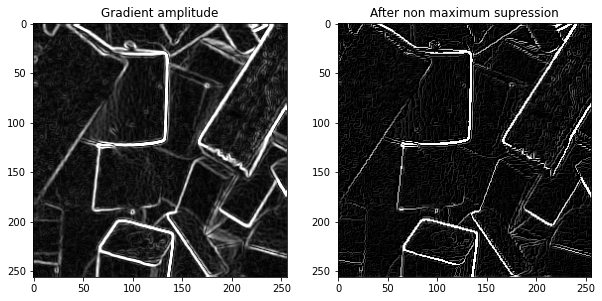

In [82]:
# ------------ To do ------------- #
fig = plt.figure(figsize=(10,20))
#fig.subplots_adjust(hspace=0.1, wspace=0.2)
plt.subplot(1,2,1)
plt.title('Gradient amplitude')
plt.imshow(amplitude_image, cmap='gray')

plt.subplot(1,2,2)
plt.title('After non maximum supression')
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.show()

## Step 4. Thresholding edges

In [88]:
def seperate(img, minimum = 60, maximum = 180):
    # ------------ To do ------------- #
    thresholding_img = img.copy()
    for i in range(thresholding_img.shape[0]):
      for j in range(thresholding_img.shape[1]):
        if thresholding_img[i][j] >= maximum:
          thresholding_img[i][j] = 255
        elif thresholding_img[i][j] <= minimum:
          thresholding_img[i][j] = 0
        else:
          thresholding_img[i][j] = 60
    return thresholding_img
thresholding = seperate(After_non_maximum_supression, minimum = 15, maximum = 90)

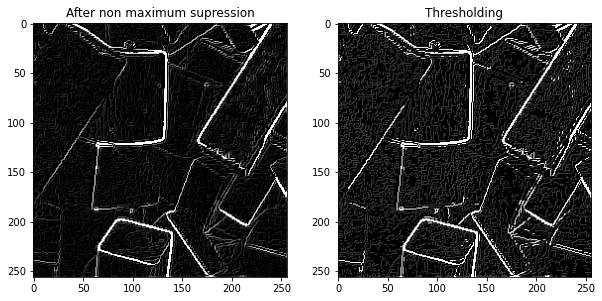

In [89]:
# ------------ To do ------------- #
fig = plt.figure(figsize=(10,20))
#fig.subplots_adjust(hspace=0.1, wspace=0.2)
plt.subplot(1,2,1)
plt.title('After non maximum supression')
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.subplot(1,2,2)
plt.title('Thresholding')
plt.imshow(thresholding, cmap='gray')

plt.show()

## Step 5. Hysteresis

In [90]:
def Connect(img,weak=60):
  # ------------ To do ------------- #
  M, N = img.shape  
  strong = 255
  for i in range(1, M-1):
    for j in range(1, N-1):
      if (img[i,j] == weak):
        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
          or (img[i, j-1] == strong) or (img[i, j+1] == strong)
          or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
          img[i, j] = strong
        else:
          img[i, j] = 0
  output = img
  return output

weak = 60
dst_img = Connect(thresholding,weak)


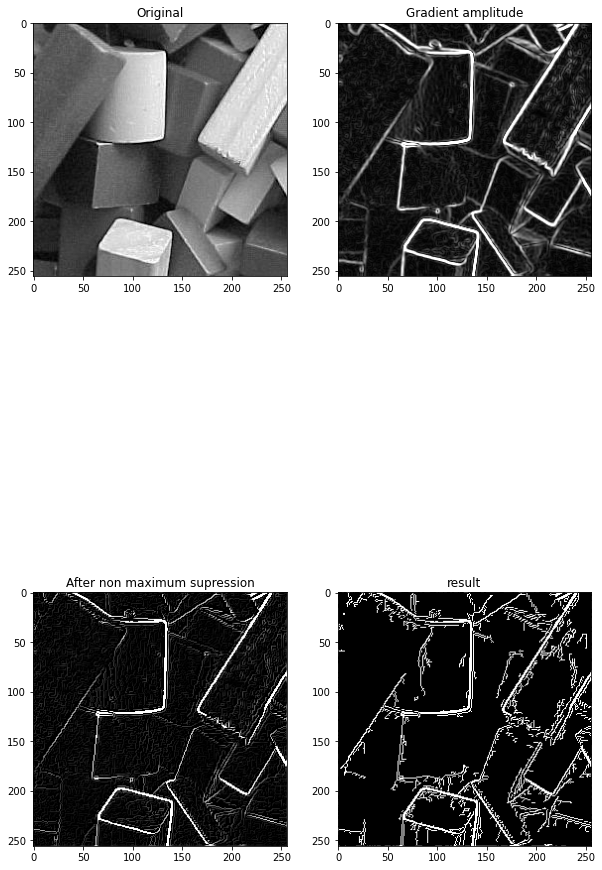

In [91]:
# ------------ To do ------------- #
fig = plt.figure(figsize=(10,20))
fig.subplots_adjust(hspace=0.1, wspace=0.2)
plt.subplot(2,2,1)
plt.title('Original')
plt.imshow(img_org, cmap='gray')

plt.subplot(2,2,2)
plt.title('Gradient amplitude')
plt.imshow(amplitude_image, cmap='gray')

plt.subplot(2,2,3)
plt.title('After non maximum supression')
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.subplot(2,2,4)
plt.title('result')
plt.imshow(dst_img, cmap='gray')

plt.show()

# Canny Edge OpenCV 套件


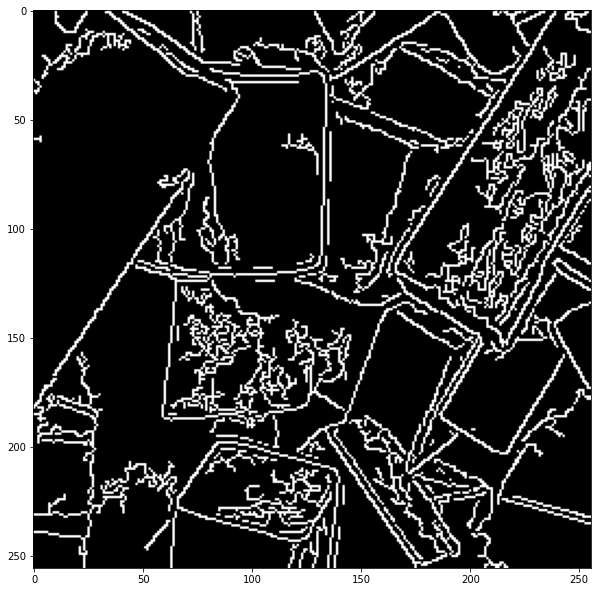

In [94]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("blocks.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

# 加分討論：為什麼和套件不一樣？

因為.....

1.non-maximum supression 沒有使用 linear interpolation，如果使用 linear interpolation可以得到更準確的結果